In [18]:
import json

import matplotlib.pyplot as plt
import network_diffusion as nd
import networkx as nx
import numpy as np
import pandas as pd

from tqdm import tqdm
from utils import functions, networks

%load_ext autoreload
%autoreload 2

functions.set_seed(42)
out_dir = "icm_mds"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ICM on Multilayer Network

In [2]:
aucs = networks.get_aucs_network()
lazega = networks.get_lazega_network()

In [3]:
print(aucs)

network parameters
--------------------------------------------
general parameters:
	number of layers: 5
	number of actors: 61

layer 'facebook' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 32
	number of edges - 124
	average degree - 7.75
	clustering coefficient - 0.5404

layer 'lunch' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 60
	number of edges - 193
	average degree - 6.4333
	clustering coefficient - 0.6733

layer 'coauthor' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 25
	number of edges - 21
	average degree - 1.68
	clustering coefficient - 0.268

layer 'leisure' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 47
	number of edges - 88
	average degree - 3.7447
	clustering coefficient - 0.3925

layer 'work' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 60
	number of edges - 194
	average degree 

In [4]:
print(lazega)

network parameters
--------------------------------------------
general parameters:
	number of layers: 3
	number of actors: 71

layer 'advice' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 71
	number of edges - 556
	average degree - 15.662
	clustering coefficient - 0.376

layer 'friendship' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 71
	number of edges - 725
	average degree - 20.4225
	clustering coefficient - 0.4493

layer 'co-work' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 70
	number of edges - 378
	average degree - 10.8
	clustering coefficient - 0.3908


In [5]:
# propagation prob: 0.1, buget 2% active
def create_mic_model(seeding_budget, seed_selector, protocol="OR", probability=0.9):
    return nd.models.MICModel(
        seeding_budget=seeding_budget,
        seed_selector=seed_selector,
        protocol=protocol,
        probability=probability,
    )

In [6]:
model_degree_01 = create_mic_model([98, 2, 0], nd.seeding.DegreeCentralitySelector())
model_degree_02 = create_mic_model([90, 10, 0], nd.seeding.DegreeCentralitySelector())

model_btw_01 = create_mic_model([98, 2, 0], nd.seeding.BetweennessSelector())
model_btw_02 = create_mic_model([90, 10, 0], nd.seeding.BetweennessSelector())

model_close_01 = create_mic_model([98, 2, 0], nd.seeding.ClosenessSelector())
model_close_02 = create_mic_model([90, 10, 0], nd.seeding.ClosenessSelector())

model_VR_01 = create_mic_model([98, 2, 0], nd.seeding.VoteRankMLNSeedSelector())
model_VR_02 = create_mic_model([90, 10, 0], nd.seeding.VoteRankMLNSeedSelector())

model_driver_01 = create_mic_model([98, 2, 0], nd.seeding.DriverActorSelector(nd.seeding.DegreeCentralitySelector()))
model_driver_02 = create_mic_model([90, 10, 0], nd.seeding.DriverActorSelector(nd.seeding.DegreeCentralitySelector()))

In [7]:
models = {
    "degree_2": model_degree_01,
    "degree_01": model_degree_02,
    "btw_2": model_btw_01,
    "btw_10": model_btw_02,
    "close_2": model_close_01,
    "close_10": model_close_02,
    "VR_2": model_VR_01,
    "VR_10": model_VR_02,
    "driver_2": model_driver_01,
    "driver_10": model_driver_02
}

In [8]:
logs_dict = {}
max_epochs = 50
n_runs = 100
patience = 1

## Lazega

In [9]:
network = lazega
nb_actors = network.get_actors_num()

In [10]:
for model_name, model in models.items():
    print(f"Running experiment for model {model_name}...")

    nb_activated_actors_model = []
    nb_epochs_model = []

    for run in tqdm(range(n_runs)):
        experiment = nd.Simulator(model, network)
        run_logs = experiment.perform_propagation(n_epochs=max_epochs, patience=patience)
        nb_activated_actors_run, nb_epochs_run = functions.convert_micm_logs(run_logs, patience)
        nb_activated_actors_model.append(nb_activated_actors_run)
        nb_epochs_model.append(nb_epochs_run)

    avg_activated_actors_model = np.mean(nb_activated_actors_model)
    avg_epochs_model = np.mean(nb_epochs_model)
    std_activated_actors_model = np.std(nb_activated_actors_model)
    std_epochs_model = np.std(nb_epochs_model)

    print(f"Activated actors: Avg = {avg_activated_actors_model}, Std = {std_activated_actors_model}")
    print(f"Epochs executed: Avg = {avg_epochs_model}, Std = {std_epochs_model}")

    logs_dict[f"logs_lazega_{model_name}"] = (
        100 * avg_activated_actors_model / nb_actors,
        avg_epochs_model,
        100 * std_activated_actors_model / nb_actors,
        std_epochs_model
    )

Running experiment for model degree_2...


100%|██████████| 100/100 [00:02<00:00, 44.71it/s]


Activated actors: Avg = 69.11, Std = 1.1738398527908314
Epochs executed: Avg = 5.17, Std = 0.548725796732758
Running experiment for model degree_01...


100%|██████████| 100/100 [00:02<00:00, 47.37it/s]


Activated actors: Avg = 68.91, Std = 1.2735383779062175
Epochs executed: Avg = 4.19, Std = 0.523354564325181
Running experiment for model btw_2...


100%|██████████| 100/100 [00:04<00:00, 20.21it/s]


Activated actors: Avg = 69.11, Std = 1.370364914904056
Epochs executed: Avg = 5.49, Std = 0.6556675987114201
Running experiment for model btw_10...


100%|██████████| 100/100 [00:04<00:00, 21.80it/s]


Activated actors: Avg = 69.09, Std = 1.2813664581219537
Epochs executed: Avg = 4.22, Std = 0.5211525688318154
Running experiment for model close_2...


100%|██████████| 100/100 [00:03<00:00, 32.99it/s]


Activated actors: Avg = 69.42, Std = 1.2262136844775464
Epochs executed: Avg = 5.31, Std = 0.5778408085277467
Running experiment for model close_10...


100%|██████████| 100/100 [00:02<00:00, 36.74it/s]


Activated actors: Avg = 69.21, Std = 1.380543371285379
Epochs executed: Avg = 4.22, Std = 0.5582114294781146
Running experiment for model VR_2...


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Activated actors: Avg = 69.26, Std = 1.221638244326036
Epochs executed: Avg = 5.25, Std = 0.5545268253204708
Running experiment for model VR_10...


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Activated actors: Avg = 69.18, Std = 1.1864231959971112
Epochs executed: Avg = 4.2, Std = 0.48989794855663554
Running experiment for model driver_2...


100%|██████████| 100/100 [00:02<00:00, 39.58it/s]


Activated actors: Avg = 69.03, Std = 1.352442235365341
Epochs executed: Avg = 5.34, Std = 0.62
Running experiment for model driver_10...


100%|██████████| 100/100 [00:02<00:00, 42.75it/s]


Activated actors: Avg = 69.05, Std = 1.5451537140362444
Epochs executed: Avg = 4.25, Std = 0.47696960070847283


## Aucs

In [11]:
network = aucs
nb_actors = network.get_actors_num()

In [12]:
for model_name, model in models.items():
    print(f"Running experiment for model {model_name}...")

    nb_activated_actors_model = []
    nb_epochs_model = []

    for run in tqdm(range(n_runs)):
        experiment = nd.Simulator(model, network)
        run_logs = experiment.perform_propagation(n_epochs=max_epochs, patience=patience)
        nb_activated_actors_run, nb_epochs_run = functions.convert_micm_logs(run_logs, patience)
        nb_activated_actors_model.append(nb_activated_actors_run)
        nb_epochs_model.append(nb_epochs_run)

    avg_activated_actors_model = np.mean(nb_activated_actors_model)
    avg_epochs_model = np.mean(nb_epochs_model)
    std_activated_actors_model = np.std(nb_activated_actors_model)
    std_epochs_model = np.std(nb_epochs_model)

    print(f"Activated actors: Avg = {avg_activated_actors_model}, Std = {std_activated_actors_model}")
    print(f"Epochs executed: Avg = {avg_epochs_model}, Std = {std_epochs_model}")

    logs_dict[f"logs_aucs_{model_name}"] = (
        100 * avg_activated_actors_model / nb_actors,
        avg_epochs_model,
        100 * std_activated_actors_model / nb_actors,
        std_epochs_model
    )

Running experiment for model degree_2...


100%|██████████| 100/100 [00:03<00:00, 33.00it/s]


Activated actors: Avg = 40.02, Std = 11.212475195067322
Epochs executed: Avg = 7.62, Std = 2.4156986567036873
Running experiment for model degree_01...


100%|██████████| 100/100 [00:02<00:00, 39.11it/s]


Activated actors: Avg = 44.13, Std = 5.256719509351816
Epochs executed: Avg = 5.61, Std = 1.0853110153315502
Running experiment for model btw_2...


100%|██████████| 100/100 [00:04<00:00, 22.57it/s]


Activated actors: Avg = 41.5, Std = 9.021640649017229
Epochs executed: Avg = 7.73, Std = 1.907118244892015
Running experiment for model btw_10...


100%|██████████| 100/100 [00:03<00:00, 25.64it/s]


Activated actors: Avg = 44.21, Std = 4.976534939091657
Epochs executed: Avg = 5.62, Std = 1.1115754585272202
Running experiment for model close_2...


100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Activated actors: Avg = 41.99, Std = 7.729805948405174
Epochs executed: Avg = 7.93, Std = 1.8828435941415844
Running experiment for model close_10...


100%|██████████| 100/100 [00:03<00:00, 32.65it/s]


Activated actors: Avg = 44.6, Std = 4.872371086031933
Epochs executed: Avg = 5.85, Std = 1.3955285736952863
Running experiment for model VR_2...


100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


Activated actors: Avg = 41.07, Std = 10.480701312412258
Epochs executed: Avg = 7.68, Std = 2.0390193721492693
Running experiment for model VR_10...


100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


Activated actors: Avg = 43.5, Std = 5.225897052181567
Epochs executed: Avg = 5.63, Std = 1.2779280104919837
Running experiment for model driver_2...


100%|██████████| 100/100 [00:03<00:00, 29.81it/s]


Activated actors: Avg = 40.71, Std = 11.698970040136011
Epochs executed: Avg = 7.95, Std = 2.570505786805391
Running experiment for model driver_10...


100%|██████████| 100/100 [00:02<00:00, 36.94it/s]

Activated actors: Avg = 44.43, Std = 5.070019723827512
Epochs executed: Avg = 5.89, Std = 1.3992497989994495


## Data concatenation

In [13]:
logs_df = pd.DataFrame(logs_dict).T.rename(
    columns={0: "avg_activated_actors_model", 1: "avg_epochs_model", 2: "std_activated_actors_model", 3: "std_epochs_model"}
)
logs_df.to_csv(f"{out_dir}/logs.csv")
logs_df

,avg_activated_actors_model,avg_epochs_model,std_activated_actors_model,std_epochs_model
logs_lazega_degree_2,97.338028,5.17,1.653296,0.548726
logs_lazega_degree_01,97.056338,4.19,1.793716,0.523355
logs_lazega_btw_2,97.338028,5.49,1.930091,0.655668
logs_lazega_btw_10,97.309859,4.22,1.804741,0.521153
logs_lazega_close_2,97.774648,5.31,1.727062,0.577841
logs_lazega_close_10,97.478873,4.22,1.944427,0.558211
logs_lazega_VR_2,97.549296,5.25,1.720617,0.554527
logs_lazega_VR_10,97.436620,4.20,1.671019,0.489898
logs_lazega_driver_2,97.225352,5.34,1.904848,0.620000
logs_lazega_driver_10,97.253521,4.25,2.176273,0.476970


## Visualisation

In [23]:
experiment = nd.Simulator(model_driver_02, aucs)
logs = experiment.perform_propagation(n_epochs=10, patience=patience)

In [24]:
# bulk logs from entire simulation that concatenate states of agents per each layer of the network
exp_01 = logs._global_stats
exp_01

[{'facebook': (('0', 26), ('1', 6)),
  'lunch': (('0', 54), ('1', 6)),
  'coauthor': (('0', 23), ('1', 2)),
  'leisure': (('0', 43), ('1', 4)),
  'work': (('0', 54), ('1', 6))},
 {'facebook': (('0', 19), ('-1', 6), ('1', 7)),
  'lunch': (('0', 41), ('1', 13), ('-1', 6)),
  'coauthor': (('0', 15), ('1', 8), ('-1', 2)),
  'leisure': (('0', 32), ('1', 11), ('-1', 4)),
  'work': (('0', 41), ('1', 13), ('-1', 6))},
 {'facebook': (('1', 10), ('-1', 13), ('0', 9)),
  'lunch': (('0', 24), ('1', 17), ('-1', 19)),
  'coauthor': (('1', 5), ('-1', 10), ('0', 10)),
  'leisure': (('1', 13), ('-1', 15), ('0', 19)),
  'work': (('1', 17), ('-1', 19), ('0', 24))},
 {'facebook': (('-1', 23), ('0', 4), ('1', 5)),
  'lunch': (('1', 11), ('-1', 36), ('0', 13)),
  'coauthor': (('-1', 15), ('1', 4), ('0', 6)),
  'leisure': (('-1', 28), ('1', 8), ('0', 11)),
  'work': (('-1', 36), ('0', 14), ('1', 10))},
 {'facebook': (('-1', 28), ('0', 3), ('1', 1)),
  'lunch': (('-1', 47), ('0', 8), ('1', 5)),
  'coauthor': 

In [25]:
# Convert the data to a JSON-compatible format
json_compatible_data = []
for record in exp_01:
    new_record = {}
    for key, value in record.items():
        new_record[key] = [list(item) for item in value]
    json_compatible_data.append(new_record)

# Write to a JSON file
file_path = f"{out_dir}/exp_visualise.json"
with open(file_path, 'w') as f:
    json.dump(json_compatible_data, f)

In [26]:
# Load the data from a JSON file
file_path = f"{out_dir}/exp_visualise.json"
with open(file_path, 'r') as f:
    loaded_data = json.load(f)

# Convert the data back to its original form
parsed_data = []
for record in loaded_data:
    new_record = {}
    for key, value in record.items():
        new_record[key] = [tuple(item) for item in value]
    parsed_data.append(new_record)

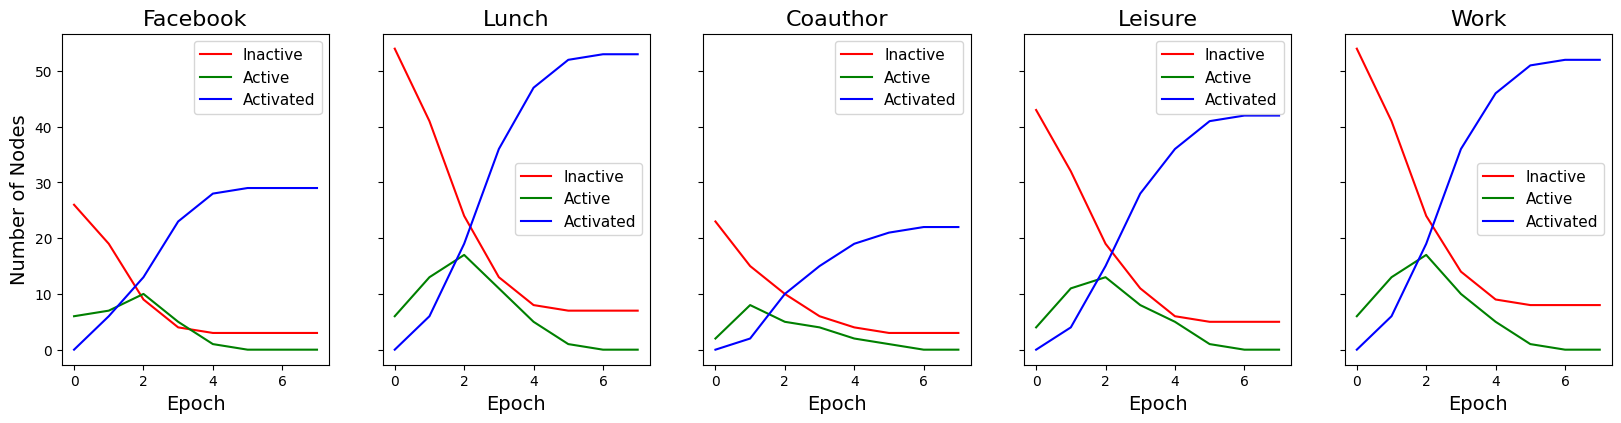

In [27]:
layers = ['facebook', 'lunch', 'coauthor', 'leisure', 'work']
statuses = ['0', '1', '-1']
status_labels = {'0': 'Inactive', '1': 'Active', '-1': 'Activated'}  # Mapping from status to label
plot_data = {layer: {status: [] for status in statuses} for layer in layers}

# Populate the plot data
for epoch, record in enumerate(parsed_data):
    for layer in layers:
        layer_data = dict(record.get(layer, []))
        for status in statuses:
            plot_data[layer][status].append(layer_data.get(status, 0))

# Generate plots
fig, axes = plt.subplots(1, len(layers), figsize=(20, 4.3), sharey=True)

for ax, layer in zip(axes, layers):
    for status, color in zip(statuses, ['r', 'g', 'b']):
        label = status_labels[status]  # Get the label from the mapping
        ax.plot(plot_data[layer][status], color=color, label=label)  # Use the label in the plot
    ax.set_title(layer.capitalize(), fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.legend(fontsize=11)

axes[0].set_ylabel('Number of Nodes', fontsize=14)
plt.savefig(f"{out_dir}/spreading.pdf", format="pdf")
plt.show()